In [1]:
import os
import sys
import os.path as op
from tqdm.notebook import trange, tqdm
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
from sklearn.decomposition import PCA

from nilearn import datasets
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from scipy.io import loadmat
from IPython.display import Image


current_dir = os.path.abspath("")
sys.path.append(current_dir)

save_results = op.join(current_dir, 'data/derivatives/pca_results/')
if not os.path.exists(save_results):
    os.makedirs(save_results)

## Load Data

In [2]:
data_path = op.join(current_dir,"data/derivatives/preprocessed_data/sub-control01/func/final/sub-control01_task-music_run-all_bold_smoothed-9mm.nii.gz")

In [3]:
img = nib.load(data_path)
affine = img.affine
data = np.asanyarray(img.dataobj)
data.shape

(80, 80, 50, 315)

## PCA Preprocessing

In [4]:
vol_shape =  data.shape[:3]
n_vols = data.shape[-1]

In [5]:
slice_non_background = data[:,:,:,0] > 0
samples = data[slice_non_background,:].T
samples.shape

(315, 71798)

In [6]:
# Calculate the mean across columns
spatial_means = np.mean(samples,axis=1)
# Row means copied n_vols times so that we substract for each timepoint the spatial mean
row_means = np.mean(samples,axis=0)
# Subtract the means for each row, put the result into X
X = samples - row_means

# Verify that the spatial mean behaves as expected after substraction
print(spatial_means.shape)
print(row_means.shape)
print(X.shape)

(315,)
(71798,)
(315, 71798)


## PCA extraction

In [7]:
from sklearn.decomposition import PCA
nb_components = 10

pca = PCA(n_components=nb_components)
pca.fit(X)

PCA(n_components=10)

Explained variance given threshold: 80.68%


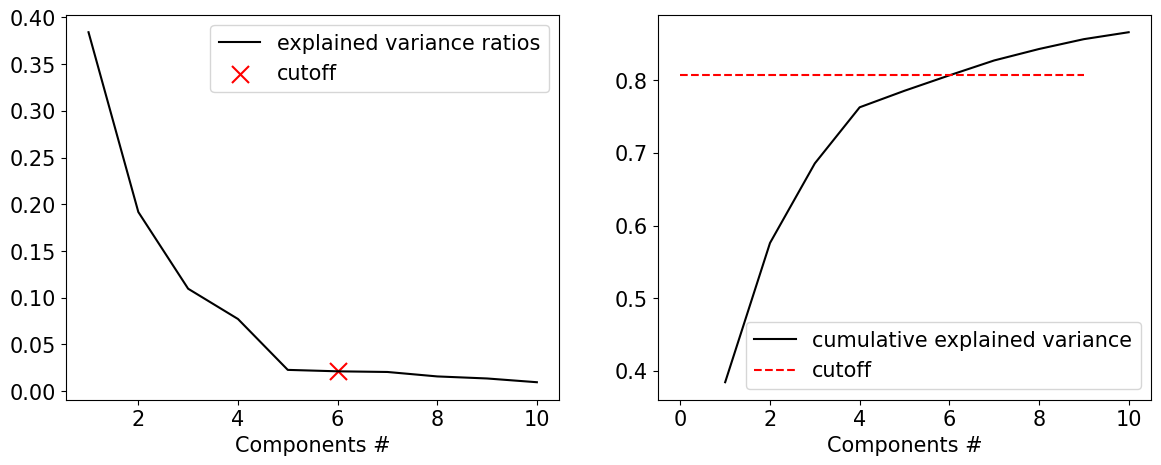

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

ratios = pca.explained_variance_ratio_
cumulative_ratios = np.cumsum(pca.explained_variance_ratio_)


thresh_dict = dict(zip(np.arange(1, len(cumulative_ratios)+1), cumulative_ratios))
thresh = 0.80
idxs = [idx for idx, val in thresh_dict.items() if val > thresh]
nb_clusters = idxs[0]

ax[0].plot(np.arange(1, len(ratios)+1), ratios, label='explained variance ratios', c='k')
ax[0].scatter([nb_clusters], [ratios[nb_clusters-1]], [150], marker='x', color='r', label='cutoff')
ax[1].plot(np.arange(1, len(cumulative_ratios)+1), cumulative_ratios, label='cumulative explained variance', c='k')
ax[1].hlines(y=cumulative_ratios[nb_clusters-1], xmin=0, xmax=len(ratios)-1, linestyle='--', color='r', label='cutoff')

for k in range(2):
    ax[k].set_xlabel('Components #', size=15)
    ax[k].legend(prop={'size':15})
    ax[k].tick_params(axis='both', which='major', labelsize=15)

print("Explained variance given threshold: {:.2%}".format(cumulative_ratios[nb_clusters-1]))

In [9]:
pca = PCA(n_components=nb_clusters)
pca.fit(X)

PCA(n_components=6)

In [10]:
pca_dims = np.zeros((nb_clusters,
                     vol_shape[0],
                     vol_shape[1],
                     vol_shape[2]))

pca_dims[:,slice_non_background] = pca.components_[:nb_clusters] 


In [11]:
mask_path = op.join(current_dir, "data/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w_mask.nii.gz")
mask = nib.load(mask_path)
masker = NiftiMasker(mask_img=mask, target_affine=affine)

/opt/conda/lib/python3.11/site-packages/nilearn/maskers/base_masker.py:320: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (y != None) while a mask has been provided at masker creation. Given mask will be used.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


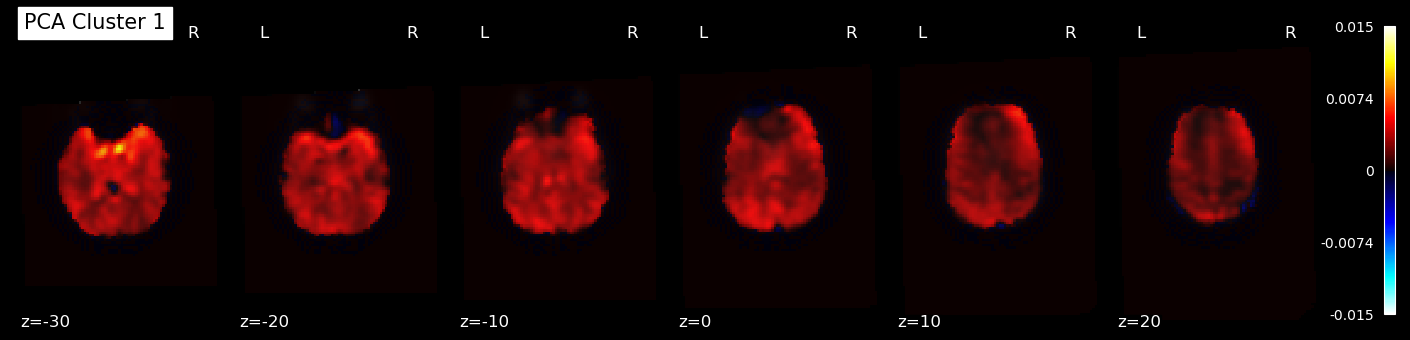

/opt/conda/lib/python3.11/site-packages/nilearn/maskers/base_masker.py:320: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (y != None) while a mask has been provided at masker creation. Given mask will be used.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


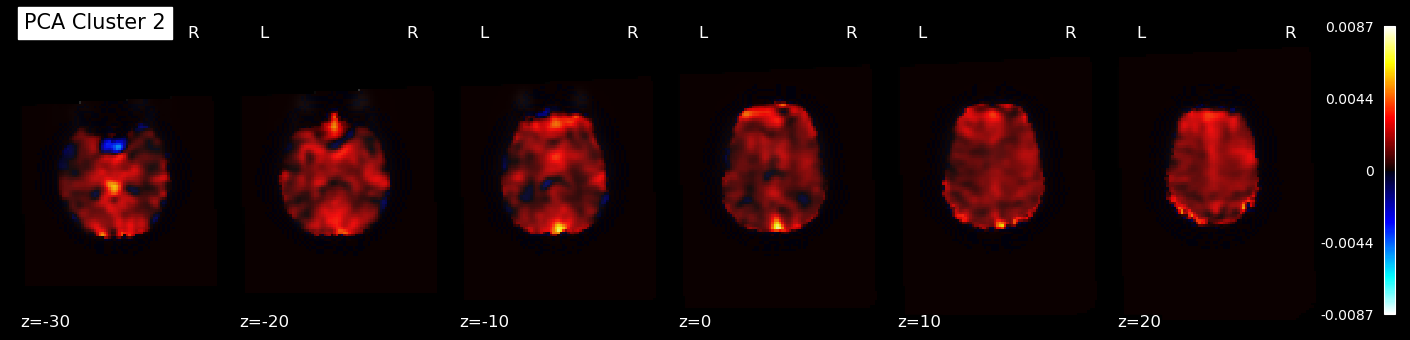

/opt/conda/lib/python3.11/site-packages/nilearn/maskers/base_masker.py:320: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (y != None) while a mask has been provided at masker creation. Given mask will be used.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


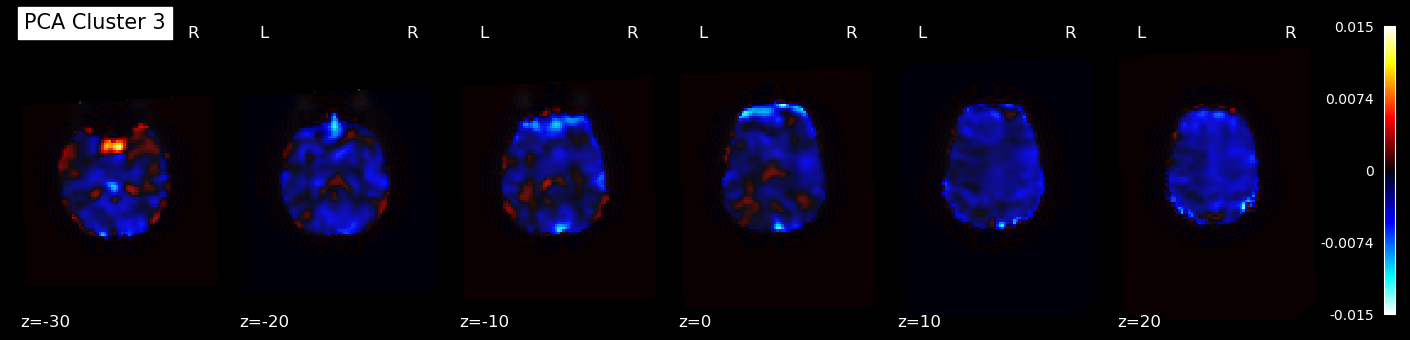

/opt/conda/lib/python3.11/site-packages/nilearn/maskers/base_masker.py:320: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (y != None) while a mask has been provided at masker creation. Given mask will be used.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


In [ ]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(img)
to_show = [x for x in np.arange(-30,30,10)]

for visual_idx in range(nb_clusters):
    img = nib.Nifti1Image(pca_dims[visual_idx], affine)
    data = masker.fit_transform(img, y=affine)
    masked = masker.inverse_transform(data)
    plot_stat_map(masked,
                  threshold=0,
                  display_mode='z',
                  cut_coords=to_show,
                  black_bg=True,
                  alpha=0.9,
                  bg_img=mean_img_,
                  title=f'PCA Cluster {visual_idx+1}')
    plt.savefig(op.join(save_results,f'pc{visual_idx+1}.png'))
    plt.show()

In [ ]:
# from nilearn import datasets, image
# from nilearn.image import resample_to_img
# import ants

# sMRI_path = op.join(current_dir, "data/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w_mni_SyN.nii.gz")
# pca_MNI_path = op.join(save_results, "phil.nii")

# def fMRI_MNI(fmri_img, sMRI_path, pca_MNI_path):
#     img = nib.load(sMRI_path)
    
#     fmri_resampled = resample_to_img(fmri_img, img, interpolation='continuous')
#     mean_fmri=mean_img(fmri_resampled)
#     fmri_resampled_path = op.join(save_results, "philly.nii")
#     mean_fmri.to_filename(fmri_resampled_path)
    
#     moving_image = ants.image_read(fmri_resampled_path)
#     fixed_image = ants.image_read(sMRI_path)
    
#     transformation = ants.registration(fixed=fixed_image, moving=moving_image, type_of_transform = 'SyN')
#     warpedImage = ants.apply_transforms(fixed=fixed_image, moving=moving_image, transformlist=transformation['fwdtransforms'])  
#     ants.image_write(warpedImage, pca_MNI_path)

#     return img, nib.load(pca_MNI_path)

# img, fMRI_MNI = fMRI_MNI(nib.Nifti1Image(pca_dims[0], affine), sMRI_path, pca_MNI_path)

In [ ]:
# from nilearn.plotting import plot_stat_map
# from nilearn.image import mean_img
# mean_img_ = mean_img(img)
# to_show = [x for x in np.arange(-30,30,5)]

# plot_stat_map(fMRI_MNI,
#                   threshold=0,
#                   display_mode='z',
#                   cut_coords=to_show,
#                   black_bg=False,
#               alpha=0.3,
#                   bg_img=img,
#                   title=f'PCA Cluster {0+1}')
    
# plt.show()

In [ ]:
# pca_MNI_path = op.join(save_results, "phil.nii")
# ants.image_write(warpedImage, pca_MNI_path)